In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np


from models.unet import Unet

from utils.utils import show_image
from utils.noise import CosineNoiseAdder

from data.dataset import MNIST_Dataset, CIFAR10_Dataset

from tqdm import tqdm

import random


In [38]:
class NoiseDataset():
    def __init__(self, imgs_dataset, noise_schedule = None):
        self.imgs_dataset = imgs_dataset
        self.noise_schedule = noise_schedule if noise_schedule else CosineNoiseAdder()       

    def __getitem__(self, idx):
        img, label = self.imgs_dataset[idx]
        t = torch.randint(self.noise_schedule.T, (1, )).squeeze()
        noisy_img, noise = self.noise_schedule.image_at_time_step(img, t)
        return noisy_img, noise, t, label

    def __len__(self):
        return len(self.imgs_dataset)

max_time_steps = 200
CosineNoise = CosineNoiseAdder(max_time_steps)

trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5,), (0.5, ))])

train = NoiseDataset(MNIST_Dataset(transform=trans), CosineNoise)
test = NoiseDataset(MNIST_Dataset('test', transform=trans), CosineNoise)

batch_size = 16
train_loader = DataLoader(train, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test, shuffle=False, batch_size=batch_size)

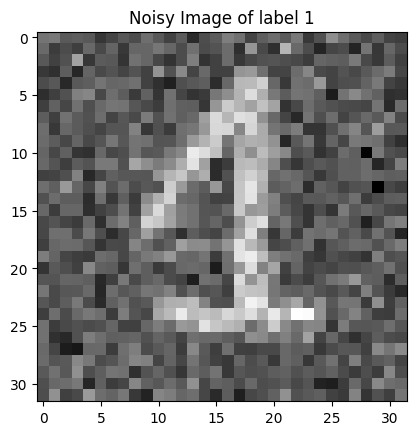

In [39]:
img, noise, t, label = train[random.randint(0, len(train))]
show_image(img, title=f'Noisy Image of label {label}')

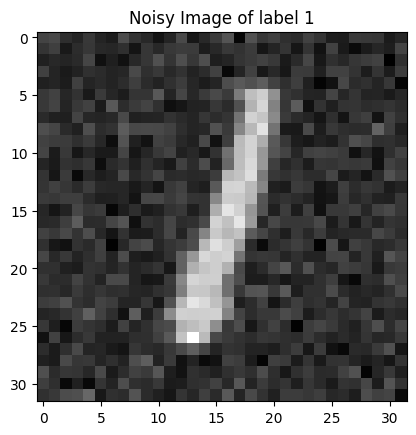

In [65]:
batch = next(iter(train_loader))
img, noise, t, label = batch
show_image(img[0], title=f'Noisy Image of label {label[0]}')

In [15]:
import torch
import torch.nn as nn

class DownBlock(nn.Module):
    def __init__(self, input_channels:int, output_channels:int, conv_layers:int=2, kernel_size:int=3, dropout:float=0.0):
        super().__init__()
        self.silu = nn.SiLU()
        self.convs = nn.ModuleList()
        self.convs.append(nn.Conv2d(input_channels, output_channels, kernel_size, padding=1))
        self.norms = nn.ModuleList([nn.BatchNorm2d(output_channels) for _ in range(conv_layers)])
        self.dropouts = nn.ModuleList([nn.Dropout(dropout) for _ in range(conv_layers)])
        for _ in range(conv_layers - 1):
            self.convs.append(nn.Conv2d(output_channels, output_channels, kernel_size, padding=1))
        self.max_pooling = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        for conv, norm, dropout in zip(self.convs, self.norms, self.dropouts):
            x = dropout(self.silu(norm(conv(x))))
        x_link = x.clone()
        x = self.max_pooling(x_link)
        return x, x_link

class BottleNeck(nn.Module):
    def __init__(self, input_channels:int, hidden_channels:int, conv_layers:int=2, kernel_size:int=3, dropout:float=0.0):
        super().__init__()
        self.convs = nn.ModuleList()
        self.convs.append(nn.Conv2d(input_channels, hidden_channels, kernel_size, padding=1))
        self.norms = nn.ModuleList([nn.BatchNorm2d(hidden_channels) for _ in range(conv_layers)])
        self.dropouts = nn.ModuleList([nn.Dropout(dropout) for _ in range(conv_layers)])
        for _ in range(conv_layers - 1):
            self.convs.append(nn.Conv2d(hidden_channels, hidden_channels, kernel_size, padding=1))
        self.up_conv = nn.ConvTranspose2d(hidden_channels, hidden_channels // 2, kernel_size=2, stride=2)
        self.silu = nn.SiLU()

    def forward(self, x):
        for conv, norm, dropout in zip(self.convs, self.norms, self.dropouts):
            x = dropout(self.silu(norm(conv(x))))
        x = self.silu(self.up_conv(x))
        return x

class UpBlock(nn.Module):
    def __init__(self, input_channels:int, conv_layers:int=2, kernel_size:int=3, dropout:float=0.0):
        super().__init__()
        self.silu = nn.SiLU()
        self.convs = nn.ModuleList()
        self.convs.append(nn.Conv2d(input_channels * 2, input_channels, kernel_size, padding=1))
        self.norms = nn.ModuleList([nn.BatchNorm2d(input_channels) for _ in range(conv_layers)])
        self.dropouts = nn.ModuleList([nn.Dropout(dropout) for _ in range(conv_layers)])
        for _ in range(conv_layers - 1):
            self.convs.append(nn.Conv2d(input_channels, input_channels, kernel_size, padding=1))
        self.up_conv = nn.ConvTranspose2d(input_channels, input_channels // 2, kernel_size=2, stride=2)

    def forward(self, x:torch.Tensor, x_connection:torch.Tensor):
        x = torch.cat([x, x_connection], dim=1)
        for conv, norm, dropout in zip(self.convs, self.norms, self.dropouts):
            x = dropout(self.silu(norm(conv(x))))
        x = self.silu(self.up_conv(x))
        return x

class FinalBlock(nn.Module):
    def __init__(self, input_channels, conv_layers:int=2, output_channels:int=3, dropout:float=0.0):
        super().__init__()
        self.silu = nn.SiLU()
        self.convs = nn.ModuleList()
        self.convs.append(nn.Conv2d(input_channels * 2, input_channels, kernel_size=3, padding=1))
        self.norms = nn.ModuleList([nn.BatchNorm2d(input_channels) for _ in range(conv_layers)])
        self.dropouts = nn.ModuleList([nn.Dropout(dropout) for _ in range(conv_layers)])
        for _ in range(conv_layers - 1):
            self.convs.append(nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1))
        self.final_conv = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)

    def forward(self, x:torch.Tensor, x_connection:torch.Tensor):
        x = torch.cat([x, x_connection], dim=1)

        for conv, norm, dropout in zip(self.convs, self.norms, self.dropouts):
            x = dropout(self.silu(norm(conv(x))))

        x = self.final_conv(x)
        return x

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = torch.log(torch.tensor(10000.0, device=device)) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class TimeEmbedding(nn.Module):
    def __init__(self, time_embed_dim, emb_dim):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_embed_dim),
            nn.Linear(time_embed_dim, emb_dim),
            nn.SiLU(),
            nn.Linear(emb_dim, emb_dim)
        )
    
    def forward(self, t):
        return self.time_mlp(t)

class LabelEmbedding(nn.Module):
    def __init__(self, num_classes, emb_dim):
        super().__init__()
        self.emb = nn.Embedding(num_classes, emb_dim)
        self.proj = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.SiLU(),
            nn.Linear(emb_dim, emb_dim)
        )
    
    def forward(self, label):
        emb = self.emb(label)
        return self.proj(emb)


class Unet(nn.Module):
    def __init__(self, first_hidden:int = 16, depth:int = 3, embed_dim:int=8, num_label:int=0, initial_channels:int=3, conv_layers:int=2, dropout:float=0.0):
        super().__init__()
        self.time_emb = TimeEmbedding(embed_dim, embed_dim)
        self.label_emb = LabelEmbedding(num_label, embed_dim) if num_label > 0 else None
        d = depth - 1
        self.down_blocks = nn.ModuleList()
        self.up_blocks = nn.ModuleList()

        self.down_blocks.append(DownBlock(initial_channels + embed_dim, first_hidden, conv_layers=conv_layers, dropout=dropout))
        for i in range(d):
            self.down_blocks.append(DownBlock(first_hidden * 2**i, first_hidden * 2**(i+1), conv_layers=conv_layers, dropout=dropout))

        self.bottleneck = BottleNeck(first_hidden*2**d, first_hidden*2**(d+1), conv_layers=3, dropout=dropout)

        for i in range(d, 0, -1):
            self.up_blocks.append(UpBlock(first_hidden * 2**i, conv_layers=conv_layers, dropout=dropout))

        self.final = FinalBlock(first_hidden, output_channels=initial_channels, conv_layers=conv_layers, dropout=dropout)


    def forward(self, x, time, label=None, verbose:int=0):
        if verbose==1: print(f'start with shape {x.shape}')
        
        time_embeddings = self.time_emb(time)
        time_embeddings = time_embeddings.unsqueeze(2).unsqueeze(3)
        time_embeddings = time_embeddings.expand(x.size(0), time_embeddings.size(1), x.size(2), x.size(3))

        embeddings = time_embeddings
        if self.label_emb:
            if verbose==1: print(f'label shape : {label.shape}')
            label_embeddings = self.label_emb(label)
            if verbose==1: print(f'label_embeddings shape : {label_embeddings.shape}')
            label_embeddings = label_embeddings.unsqueeze(2).unsqueeze(2)
            if verbose==1: print(f'label_embeddings shape : {label_embeddings.shape}')
            label_embeddings = label_embeddings.expand(x.size(0), label_embeddings.size(1), x.size(2), x.size(3))
            if verbose==1: print(f'label_embeddings shape : {label_embeddings.shape}')
            embeddings = embeddings + label_embeddings
            
        x = torch.cat([x, embeddings], dim=1)
        
        if verbose==1: print(f'after concatenating the timestep (& labels) embedds : {x.shape}')

        skips = []
        for i, block in enumerate(self.down_blocks):
            if verbose==1: print(f'down block {i}, with shape {x.shape}')
            x, xi = block(x)
            skips.append(xi)

        x = self.bottleneck(x)
        if verbose==1: print(f'after bottleneck : shape = {x.shape}')
    


        for i, block in enumerate(self.up_blocks):
            skip = skips.pop()
            if verbose==1: print(f'up block {i}, with shape {x.shape}, and skip shape : {skip.shape}')
            x = block(x, skip)

        x = self.final(x, skips[0])
        if verbose==1: print(f'after final : shape = {x.shape}')

        return x

In [27]:
# testing net shapes
net = Unet(32, depth=3, embed_dim=16,
           num_label=10, initial_channels=3, conv_layers=2)

test_img = torch.randn(1, 3, 32, 32)
test_time = torch.tensor([1])
test_label = torch.tensor([1])
print(net(test_img, test_time, test_label, verbose=True).shape)

start with shape torch.Size([1, 3, 32, 32])
label shape : torch.Size([1])
label_embeddings shape : torch.Size([1, 16])
label_embeddings shape : torch.Size([1, 16, 1, 1])
label_embeddings shape : torch.Size([1, 16, 32, 32])
after concatenating the timestep (& labels) embedds : torch.Size([1, 19, 32, 32])
down block 0, with shape torch.Size([1, 19, 32, 32])
down block 1, with shape torch.Size([1, 32, 16, 16])
down block 2, with shape torch.Size([1, 64, 8, 8])
after bottleneck : shape = torch.Size([1, 128, 8, 8])
up block 0, with shape torch.Size([1, 128, 8, 8]), and skip shape : torch.Size([1, 128, 8, 8])
up block 1, with shape torch.Size([1, 64, 16, 16]), and skip shape : torch.Size([1, 64, 16, 16])
after final : shape = torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])


## Sample

In [ ]:
net.load_state_dict(torch.load('best_model_MNIST.pth'))
net.eval()

In [ ]:
max_time_steps = 200
n_samples = 10
device = 'cuda'
xt = torch.randn((1, 1, 32, 32)).to(device)
T = max_time_steps
s = 0.008

# 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
label = torch.tensor([5], device=device)

CosineNoise = CosineNoiseAdder(max_time_steps, s)

# print(CosineNoise.get_alpha_t(T))
for _ in range(n_samples):
    with torch.no_grad():
        full_img = torch.tensor([], device=device)
        full_predicted_noise = torch.tensor([], device=device)
    
        xt = torch.randn((1, initial_channels, 32, 32)).to(device)
        for t in torch.arange(max_time_steps-1, -1, -1):
            t = t.expand((1)).to(device)
            a_t = CosineNoise.get_alpha_t(t)
            alpha_t_barre = CosineNoise.get_alpha_t_barre(t)
            sigma = torch.sqrt(1-a_t).view(1, 1, 1, 1)
            z = torch.randn_like(xt)
            # print(xt.shape)
            epsilon = net(xt, t, label)
            
            if t > 0:
                noise = torch.randn_like(xt)
                sigma_t = torch.sqrt(1 - a_t).view(1, 1, 1, 1)
            else:
                noise = torch.zeros_like(xt)
                sigma_t = torch.zeros_like(a_t).view(1, 1, 1, 1)

            a = ((1 - a_t)/(torch.sqrt(1 - alpha_t_barre))).view(1, 1, 1, 1)
            b = (1/torch.sqrt(a_t)).view(1, 1, 1, 1)
            
            if t.item() % (max_time_steps / 10) == 0 or t.item() == max_time_steps-1:
                # print(t.item())
                full_img = torch.cat((full_img, xt), 3)
                full_predicted_noise = torch.cat((full_predicted_noise, epsilon), 3)
                # print(xt.shape)
                # show_image(xt[0], f'{t.item()}%')
                # show_image(full_img[0])
            
            # print(t[0].item(), a_t[0].item(), alpha_t_barre[0].item(), sigma[0].item(), a[0].item(), b[0].item(), z.shape, epsilon.shape, sep=' | ')
            # print(xt.shape, epsilon.shape)
            
            xt = b*(xt - a*epsilon) + sigma*z

            # xt = torch.sqrt(1 - a_t).view(1, 1, 1, 1) * epsilon + sigma * z
            
            # xt = b * (xt - torch.sqrt(1-alpha_t_barre)*epsilon) + sigma*z
            
            # print(xt[0][0][0][0], xt[0][1][0][0], xt[0][2][0][0])
            # print(xt[0])

        show_image(xt[0])
        
    # print(full_img.shape)
        show_image(full_img[0])
        # show_image(full_predicted_noise[0])
        

## Set up

In [ ]:
class CFG:
    # dataset
    batch_size = 4
    
    # noise
    B_0 = 1e-4
    B_T = 2e-2
    T = 500
    schedule_type = 'cosine'
    s = 0.008

## Noise Dataset

In [ ]:
class NoiseDataset():
    def __init__(self, imgs_dataset, noise_schedule = None):
        self.imgs_dataset = imgs_dataset
        self.noise_schedule = noise_schedule if noise_schedule else CosineNoiseAdder()       

    def __getitem__(self, idx):
        img, label = self.imgs_dataset[idx]
        t = torch.randint(self.noise_schedule.T, (1, )).squeeze()
        noisy_img, noise = self.noise_schedule.image_at_time_step(img, t)
        return noisy_img, noise, t, label

    def __len__(self):
        return len(self.imgs_dataset)

## Training

### Weight Initialization

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight, gain=1)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


In [ ]:
def eval_model(model:nn.Module, _test_loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for i, (noisy_imgs, noises, time_steps, labels) in enumerate(_test_loader):
            noisy_imgs, noises, time_steps, labels = noisy_imgs.to(device), noises.to(device), time_steps.to(device), labels.to(device)
            outputs = model(noisy_imgs, time_steps, labels)
            loss = criterion(outputs, noises)
            losses.append(loss.item())
            # print(loss, losses)
            # print(f"Batch {i}, Loss: {loss.item()}")
    return sum(losses)/len(losses)

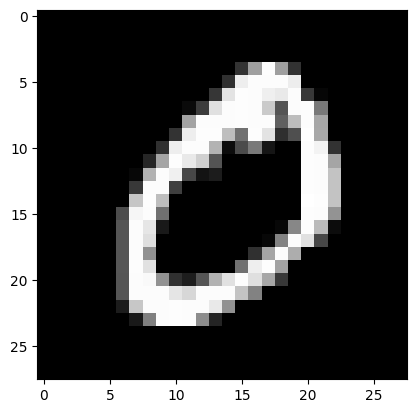

0


In [ ]:
datas = MNIST_Dataset()
show_image(datas[1][0])
print(datas[1][1])

### Training Loop

Using device: cuda


Epoch 10/10: 100%|██████████| 3750/3750 [01:12<00:00, 51.87it/s, Loss=0.174, Val Loss=0.173, lr=1.01e-5]


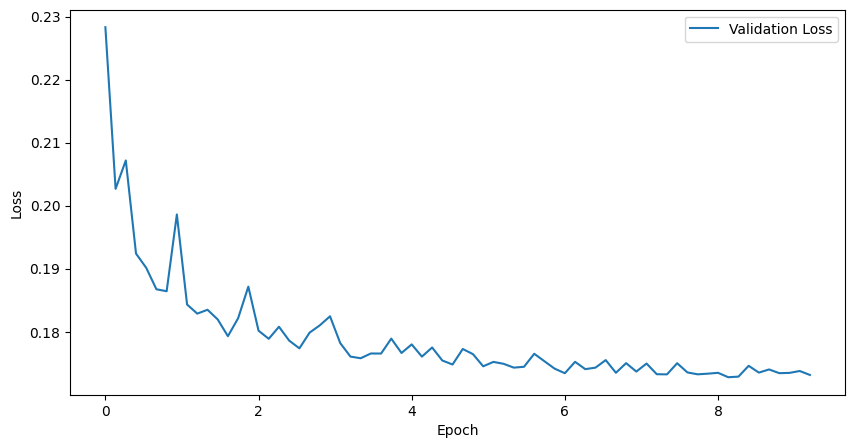

In [ ]:
# hyperparameters

n_epochs = 10
batch_size = 16
lr = 1e-3
max_time_steps = 100
eval_every = 500
patience = 5000

# model creation
net = Unet(64, depth=2, time_embed_dim=16, label_emb_dim=16,
           num_label=10, initial_channels=1, conv_layers=1)
net.apply(init_weights)

# dataset creation
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize((0.5,), (0.5,))])
CosineNoise = CosineNoiseAdder(max_time_steps)
train = NoiseDataset(MNIST_Dataset(transform=trans), CosineNoise)
test = NoiseDataset(MNIST_Dataset('test', transform=trans), CosineNoise)
train_loader = DataLoader(train, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test, shuffle=False, batch_size=batch_size)

# loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1,  gamma=0.316)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=n_epochs * len(train_loader), eta_min=1e-5)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=50, min_lr=1e-4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
net.to(device)

# keep track of the loss
train_losses = []
val_losses = []
best_loss = np.inf
best_loss_i = 0
stoping = False

# training loop
for epoch in range(n_epochs):
    net.train()
    train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epochs}', leave=True)
    for i, batch in enumerate(train_loader_tqdm):
        noisy_imgs, noises, time_steps, labels = batch
        noisy_imgs, noises, time_steps, labels = noisy_imgs.to(
            device), noises.to(device), time_steps.to(device), labels.to(device)
        # print(noisy_imgs.shape, noises.shape, time_steps.shape, labels.shape)

        optimizer.zero_grad()

        predicted_noise = net(noisy_imgs, time_steps, labels, verbose=False)
        loss = criterion(predicted_noise, noises)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        optimizer.step()

        train_losses.append(loss.item())

        if i % eval_every == 0 and i > 0:
            
            val_loss = eval_model(net, test_loader, criterion, device)
            val_losses.append(val_loss)
            # print(f'Epoch [{epoch+1}/{n_epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, lr: {scheduler.get_last_lr()[0]}')
            train_loader_tqdm.set_postfix({'Loss': loss.item(), 'Val Loss': val_loss, 'lr': scheduler.get_last_lr()[0]})

            
            if val_loss < best_loss:
                best_loss = val_loss
                best_loss_i = epoch * len(train_loader) + i
                torch.save(net.state_dict(), 'best_model_MNIST.pth')

            if epoch * len(train_loader) + i - best_loss_i > patience:
                print("Stopping early")
                stoping = True
                break

        show_image(noisy_imgs[0], title="noisy image")
        show_image(predicted_noise[0], title="predicted noise")

        break
        scheduler.step()
        # train_loader_tqdm.set_postfix({'Loss': loss.item(), 'Val Loss': val_loss, 'lr': scheduler.get_last_lr()[0]})
    # if epoch % 4 == 0:
    #     scheduler.step()
    if stoping:
        break
    break

plt.figure(figsize=(10, 5))
# plt.plot(train_losses, label='Training Loss')
plt.plot(np.arange(0, len(val_losses)) * eval_every /
         len(train_loader), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
net.load_state_dict(torch.load('best_model_MNIST.pth'))

<All keys matched successfully>

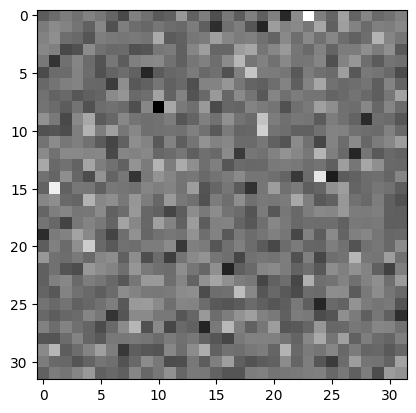

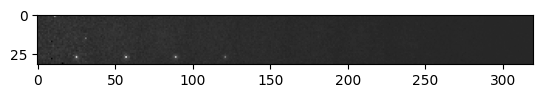

In [ ]:
max_time_steps = 100

n_samples = 1
xt = torch.randn((n_samples, 1, 32, 32)).to(device)
T = max_time_steps
s = 0.008

# 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
label = torch.tensor([1], device=device)

CosineNoise = CosineNoiseAdder(max_time_steps, s)

# print(CosineNoise.get_alpha_t(T))
for _ in range(1):
    with torch.no_grad():
        full_img = torch.tensor([], device=device)
        full_predicted_noise = torch.tensor([], device=device)
    
        xt = torch.randn((n_samples, 1, 32, 32)).to(device)
        for t in torch.arange(max_time_steps-1, -1, -1):
            t = t.expand((n_samples)).to(device)
            a_t = CosineNoise.get_alpha_t(t)
            alpha_t_barre = CosineNoise.get_alpha_t_barre(t)
            sigma = torch.sqrt(1-a_t).view(n_samples, 1, 1, 1)
            z = torch.randn_like(xt)
            # print(xt.shape)
            epsilon = net(xt, t, label)
            a = ((1 - a_t)/(torch.sqrt(1 - alpha_t_barre))).view(n_samples, 1, 1, 1)
            b = (1/torch.sqrt(a_t)).view(n_samples, 1, 1, 1)
            
            if t.item() % (max_time_steps / 10) == 0:
                # print(t.item())
                full_img = torch.cat((full_img, xt), 3)
                full_predicted_noise = torch.cat((full_predicted_noise, epsilon), 3)
                # print(xt.shape)
                # show_image(xt[0])
                # show_image(full_img[0])
            
            # print(t[0].item(), a_t[0].item(), alpha_t_barre[0].item(), sigma[0].item(), a[0].item(), b[0].item(), z.shape, epsilon.shape, sep=' | ')
            # print(xt.shape, epsilon.shape)
            
            # xt = b*(xt - a*epsilon) + sigma*z

            # xt = torch.sqrt(1 - a_t).view(n_samples, 1, 1, 1) * epsilon + sigma * z
            
            xt = b * (xt - torch.sqrt(1-alpha_t_barre)*epsilon) + sigma*z
            
            # print(xt[0][0][0][0], xt[0][1][0][0], xt[0][2][0][0])
            # print(xt[0])

        show_image(xt[0])
        
    # print(full_img.shape)
        show_image(full_img[0])
        # show_image(full_predicted_noise[0])